<a href="https://colab.research.google.com/github/sevinpr/Synthetic-Sniffer/blob/main/HDE_FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading dataset from kaggle

StyleGAN & Flickr for training and validation

In [4]:
import kagglehub
import shutil
import os

# Specify the desired download path
download_path = "/content/dataset"

# Create the directory if it doesn't exist
os.makedirs(download_path, exist_ok=True)

# Download the dataset to the specified path
path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")
print("Path to dataset files:", path)


# Define source and destination paths
source_path = '/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2'
destination_path = '/content/dataset'

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Iterate through all files and directories in the source path
for item in os.listdir(source_path):
    source_item_path = os.path.join(source_path, item)
    destination_item_path = os.path.join(destination_path, item)

    # Move the item to the destination path
    shutil.move(source_item_path, destination_item_path)

print(f"Files moved from '{source_path}' to '{destination_path}' successfully.")


Path to dataset files: /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2
Files moved from '/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2' to '/content/dataset' successfully.


PRO-GAN dataset for testing

In [1]:
import kagglehub
import os
from torchvision import datasets

# Download latest version
path = kagglehub.dataset_download("mayankjha146025/fake-face-images-generated-from-different-gans")
print("Path to dataset files:", path)

# Check if the dataset contains an 'images' folder
# If not, adjust the folder name accordingly
if not os.path.exists(os.path.join(path, 'images')):
    # List all folders in the dataset path
    folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    if folders:
        # Assume the first folder in the list is the correct one
        image_folder_path = os.path.join(path, folders[0])
    else:
        raise FileNotFoundError("No subfolders found in the dataset directory.")
else:
    image_folder_path = os.path.join(path, 'images')

# Create an ImageFolder dataset object to easily access the data
dataset = datasets.ImageFolder(image_folder_path)

# Print the total number of samples in the dataset
print("Total number of data samples:", len(dataset))

100%|██████████| 1.60G/1.60G [00:16<00:00, 103MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mayankjha146025/fake-face-images-generated-from-different-gans/versions/1
Total number of data samples: 21300


Swap the testing folder to test with PROGAN

In [ ]:
import os
import shutil
import random

# 1. Delete content in /content/dataset/real_vs_fake/real-vs-fake/test/fake
fake_folder = '/content/dataset/real_vs_fake/real-vs-fake/test/fake'
for filename in os.listdir(fake_folder):
    file_path = os.path.join(fake_folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

# 2. Randomly delete 2100 images from /content/dataset/real_vs_fake/real-vs-fake/test/real
real_folder = '/content/dataset/real_vs_fake/real-vs-fake/test/real'
real_images = os.listdir(real_folder)
images_to_delete = random.sample(real_images, 2900)
for image in images_to_delete:
    image_path = os.path.join(real_folder, image)
    os.remove(image_path)

# 3. Move images from /content/fake-face-images-generated-from-different-gans/GAN_Generated_Fake_Images/ProGAN_128x128 to /content/dataset/real_vs_fake/real-vs-fake/test/fake
source_folder = '/content/fake-face-images-generated-from-different-gans/GAN_Generated_Fake_Images/ProGAN_128x128'
for filename in os.listdir(source_folder):
    source_path = os.path.join(source_folder, filename)
    destination_path = os.path.join(fake_folder, filename)
    shutil.move(source_path, destination_path)

print("Operations completed successfully.")

Operations completed successfully.


# Data Loading and Augmentation

In [6]:

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [5]:
def check_data_quantity(dataset, dataset_name):
    print(f"Dataset: {dataset_name}")
    print(f"  Total samples: {len(dataset)}")
    # If the dataset is an instance of ImageFolder, it contains a 'targets' attribute.
    if hasattr(dataset, 'targets'):
        from collections import Counter
        counts = Counter(dataset.targets)
        # Map numeric labels back to class names using class_to_idx
        idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
        print("  Class distribution:")
        for cls, count in counts.items():
            print(f"    {idx_to_class[cls]}: {count}")
    else:
        print("  No target information available.")



In [7]:

# Define data transforms (including augmentations)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Adjust these paths to your dataset locations in Colab
train_data = datasets.ImageFolder('/content/dataset/real_vs_fake/real-vs-fake/train', transform=train_transforms)
val_data   = datasets.ImageFolder('/content/dataset/real_vs_fake/real-vs-fake/valid', transform=val_test_transforms)
test_data  = datasets.ImageFolder('/content/dataset/real_vs_fake/real-vs-fake/test', transform=val_test_transforms)

# Check data quantity for each dataset
check_data_quantity(train_data, "Train")
check_data_quantity(val_data, "Validation")
check_data_quantity(test_data, "Test")

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)


Dataset: Train
  Total samples: 100000
  Class distribution:
    fake: 50000
    real: 50000
Dataset: Validation
  Total samples: 20000
  Class distribution:
    fake: 10000
    real: 10000
Dataset: Test
  Total samples: 20000
  Class distribution:
    fake: 10000
    real: 10000


In [9]:
# Define the target size (consistent with your model's FC layer)
IMAGE_SIZE = 256

# Define data transforms (including augmentations and RESIZING)
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])


# --- Check if preprocessed data exists, otherwise create and save ---
train_data_path = 'preprocessed_train_data.pt'
val_data_path = 'preprocessed_val_data.pt'
test_data_path = 'preprocessed_test_data.pt'

if os.path.exists(train_data_path) and os.path.exists(val_data_path) and os.path.exists(test_data_path):
    # Load preprocessed data
    train_data = torch.load(train_data_path)
    val_data = torch.load(val_data_path)
    test_data = torch.load(test_data_path)
else:
    # Create and save preprocessed data
    train_data = datasets.ImageFolder('/content/dataset/real_vs_fake/real-vs-fake/train', transform=train_transforms)
    val_data = datasets.ImageFolder('/content/dataset/real_vs_fake/real-vs-fake/valid', transform=val_test_transforms)
    test_data = datasets.ImageFolder('/content/dataset/real_vs_fake/real-vs-fake/test', transform=val_test_transforms)

    torch.save(train_data, train_data_path)
    torch.save(val_data, val_data_path)
    torch.save(test_data, test_data_path)

# --- Re-define your DataLoaders ---
batch_size = 64  # Adjust based on your GPU memory
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


In [10]:
# --- Add this cell after the DataLoader definition cell ---

# Get a sample from the training dataset to check the shape after transforms
print("Checking shape of a sample image after preprocessing:")
# Retrieve the first sample (image tensor and its label) from the train_data
sample_image_tensor, sample_label = train_data[0]

# The transforms.ToTensor() step moves the channel dimension to the front (C, H, W)
# The transforms.Normalize() step does not change the shape.
print(f"  Type of the preprocessed image: {type(sample_image_tensor)}")
print(f"  Shape of the preprocessed image (Channels, Height, Width): {sample_image_tensor.shape}")
print(f"  Label of the sample: {sample_label} (Class: {train_data.classes[sample_label]})") # Optional: see label

# You can also check the shape of a batch from the DataLoader
print("\nChecking shape of a batch from the DataLoader:")
# Get one batch of data from the train_loader
images_batch, labels_batch = next(iter(train_loader))
print(f"  Shape of an image batch (Batch Size, Channels, Height, Width): {images_batch.shape}")
print(f"  Shape of a label batch (Batch Size): {labels_batch.shape}") # Optional: see labels shape

Checking shape of a sample image after preprocessing:
  Type of the preprocessed image: <class 'torch.Tensor'>
  Shape of the preprocessed image (Channels, Height, Width): torch.Size([3, 256, 256])
  Label of the sample: 0 (Class: fake)

Checking shape of a batch from the DataLoader:
  Shape of an image batch (Batch Size, Channels, Height, Width): torch.Size([64, 3, 256, 256])
  Shape of a label batch (Batch Size): torch.Size([64])


In [11]:
# Get a sample from the test dataset to check the shape after transforms
print("\nChecking shape of a sample TEST image after preprocessing:")
# Retrieve the first sample (image tensor and its label) from the test_data
sample_test_image_tensor, sample_test_label = test_data[0]

# The transforms.ToTensor() step moves the channel dimension to the front (C, H, W)
# The transforms.Normalize() step does not change the shape.
print(f"  Type of the preprocessed test image: {type(sample_test_image_tensor)}")
print(f"  Shape of the preprocessed test image (Channels, Height, Width): {sample_test_image_tensor.shape}")
print(f"  Label of the test sample: {sample_test_label} (Class: {test_data.classes[sample_test_label]})") # Optional: see label

# You can also check the shape of a batch from the test DataLoader
print("\nChecking shape of a batch from the TEST DataLoader:")
# Get one batch of data from the test_loader
test_images_batch, test_labels_batch = next(iter(test_loader))
print(f"  Shape of a test image batch (Batch Size, Channels, Height, Width): {test_images_batch.shape}")
print(f"  Shape of a test label batch (Batch Size): {test_labels_batch.shape}") # Optional: see labels shape


Checking shape of a sample TEST image after preprocessing:
  Type of the preprocessed test image: <class 'torch.Tensor'>
  Shape of the preprocessed test image (Channels, Height, Width): torch.Size([3, 256, 256])
  Label of the test sample: 0 (Class: fake)

Checking shape of a batch from the TEST DataLoader:
  Shape of a test image batch (Batch Size, Channels, Height, Width): torch.Size([64, 3, 256, 256])
  Shape of a test label batch (Batch Size): torch.Size([64])


# First-Level Disentanglement: DR-GAN Module

In [12]:
from torchvision import models

class DRGANEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(DRGANEncoder, self).__init__()
        self.features = nn.Sequential(
            # Simple CNN architecture; you can replace with a deeper network.
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 256->128
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128->64
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 64->32
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 32->16
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Linear(512*16*16, latent_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        latent = self.fc(x)
        return latent

class DRGANEncoder(nn.Module):
    def __init__(self, latent_dim=128, freeze_backbone=True):
        super(DRGANEncoder, self).__init__()
        # Example using ResNet50
        backbone = models.resnet50(pretrained=True)
        # Remove the original classifier
        self.features = nn.Sequential(*list(backbone.children())[:-1])

        if freeze_backbone:
            for param in self.features.parameters():
                param.requires_grad = False

        # Adjust the input dimension of the FC layer based on backbone output
        # ResNet50 output feature dim is 2048
        num_ftrs = backbone.fc.in_features # or simply 2048 for ResNet50
        self.fc = nn.Linear(num_ftrs, latent_dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) # Flatten features
        latent = self.fc(x)
        return latent

class DRGANDecoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(DRGANDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 512*16*16)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 16->32
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 32->64
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 64->128
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # 128->256
            nn.Tanh()  # Assuming image pixels in [-1, 1]
        )

    def forward(self, latent):
        x = self.fc(latent)
        x = x.view(x.size(0), 512, 16, 16)
        rec = self.deconv(x)
        return rec

class DRGAN(nn.Module):
    def __init__(self, latent_dim=128):
        super(DRGAN, self).__init__()
        self.encoder = DRGANEncoder(latent_dim=latent_dim)
        self.decoder = DRGANDecoder(latent_dim=latent_dim)
        # A simple classifier to differentiate real vs. fake based on latent code
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2)  # 2 classes: real, fake
        )

    def forward(self, x):
        latent = self.encoder(x)
        rec = self.decoder(latent)
        class_logits = self.classifier(latent)
        return latent, rec, class_logits


#  Second-Level Analysis: Multi-Pathway Modules

In [13]:

class SemanticPathway(nn.Module):
    def __init__(self, in_dim=128, out_dim=64):
        super(SemanticPathway, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(inplace=True),
            nn.Linear(out_dim, out_dim)
        )

    def forward(self, latent):
        return self.net(latent)

class FrequencyPathway(nn.Module):
    def __init__(self, in_dim=128, out_dim=64):
        super(FrequencyPathway, self).__init__()
        # Here we simulate frequency analysis by applying an FFT (could be extended)
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(inplace=True),
            nn.Linear(out_dim, out_dim)
        )

    def forward(self, latent):
        # Compute a pseudo frequency representation
        # Note: For a real implementation, consider applying a Fourier transform on the image domain.
        freq_repr = torch.abs(torch.fft.fft(latent, norm="ortho"))
        return self.net(freq_repr)

class BiologicalPathway(nn.Module):
    def __init__(self, in_dim=128, out_dim=64):
        super(BiologicalPathway, self).__init__()
        # Focus on eye region artifacts; in practice, you may crop eye regions.
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(inplace=True),
            nn.Linear(out_dim, out_dim)
        )

    def forward(self, latent):
        return self.net(latent)


# Contrastive Refinement Layer

In [15]:

class ContrastiveRefinement(nn.Module):
    def __init__(self, in_dim=128, out_dim=64):
        super(ContrastiveRefinement, self).__init__()
        self.projector = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(inplace=True),
            nn.Linear(out_dim, out_dim)
        )

    def forward(self, latent):
        # Project latent representation into contrastive space.
        return self.projector(latent)

    def contrastive_loss(self, z1, z2):
        # A simple L2 loss between projections for positive pairs.
        return ((z1 - z2)**2).mean()


# Adversarial Equilibrium Component (NashAE-Inspired)

In [16]:

class NashAE(nn.Module):
    def __init__(self, in_dim=128, latent_dim=64):
        super(NashAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, latent_dim),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, in_dim),
            nn.ReLU(inplace=True)
        )
        # Discriminator to enforce a prior (e.g. sparse latent space)
        self.discriminator = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, latent):
        z = self.encoder(latent)
        rec = self.decoder(z)
        d_score = self.discriminator(z)
        return z, rec, d_score


# Decision Fusion Mechanism

In [17]:

class DecisionFusion(nn.Module):
    def __init__(self, in_dims=[64, 64, 64, 64, 64], out_dim=2):
        super(DecisionFusion, self).__init__()
        total_dim = sum(in_dims)
        self.fc = nn.Sequential(
            nn.Linear(total_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, out_dim)
        )

    def forward(self, semantic, frequency, biological, contrastive, nash):
        # Simulate dynamic weighting (here simply concatenating features)
        # In practice, you could compute TAD metrics and use them as weights.
        fused_features = torch.cat([semantic, frequency, biological, contrastive, nash], dim=1)
        return self.fc(fused_features)


# Assemble the Full Hierarchical Disentanglement Ensemble (HDE)

In [18]:
class HDE(nn.Module):
    def __init__(self, latent_dim=128):
        super(HDE, self).__init__()
        # First-level disentanglement via DR-GAN
        self.drgan = DRGAN(latent_dim=latent_dim)

        # Second-level analysis: three pathways (each output dimension = 64)
        self.semantic = SemanticPathway(in_dim=latent_dim, out_dim=64)
        self.frequency = FrequencyPathway(in_dim=latent_dim, out_dim=64)
        self.biological = BiologicalPathway(in_dim=latent_dim, out_dim=64)

        # Contrastive refinement
        self.contrastive = ContrastiveRefinement(in_dim=latent_dim, out_dim=64)

        # Adversarial equilibrium component (NashAE-inspired)
        self.nash = NashAE(in_dim=latent_dim, latent_dim=64)

        # Decision fusion: fuse five 64-dim features into classification logits (real vs fake)
        self.fusion = DecisionFusion(in_dims=[64,64,64,64,64], out_dim=2)

    def forward(self, x):
        # First-level: DR-GAN disentanglement
        latent, rec, class_logits = self.drgan(x)

        # Second-level: process latent through parallel pathways
        semantic_feat  = self.semantic(latent)
        frequency_feat = self.frequency(latent)
        biological_feat = self.biological(latent)
        contrastive_feat = self.contrastive(latent)
        nash_z, nash_rec, nash_dscore = self.nash(latent)

        # Fusion: combine all pathways dynamically
        fused_logits = self.fusion(semantic_feat, frequency_feat, biological_feat, contrastive_feat, nash_z)

        # The overall loss will combine:
        # - Classification loss (from DR-GAN and fusion output)
        # - Reconstruction losses (from DR-GAN and NashAE)
        # - Contrastive loss (from the contrastive module)
        # - Adversarial loss (from NashAE discriminator)
        return {
            'latent': latent,
            'drgan_rec': rec,
            'drgan_class': class_logits,
            'semantic': semantic_feat,
            'frequency': frequency_feat,
            'biological': biological_feat,
            'contrastive': contrastive_feat,
            'nash_z': nash_z,
            'nash_rec': nash_rec,
            'nash_dscore': nash_dscore,
            'fused_logits': fused_logits
        }


# Training and Evaluation Routines

In [ ]:

def train_epoch(model, dataloader, optimizer, device, criterion_cls, scaler,
                lambda_rec=1.0, lambda_adv=0.1, lambda_ctr=0.1, accumulation_steps=1):
    model.train()
    total_loss = 0
    num_steps = 0  # Keep track of the number of optimization steps

    for i, (imgs, labels) in enumerate(dataloader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Mixed precision training
        with amp.autocast():
            outputs = model(imgs)

            # ... (your loss calculations as before) ...

        # Gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            num_steps += 1

        total_loss += loss.item()

    return total_loss / num_steps

def evaluate(model, dataloader, device, criterion_cls):
    model.eval()
    all_preds = []
    all_labels = []
    losses = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion_cls(outputs['fused_logits'], labels)
            losses += loss.item()
            preds = torch.argmax(outputs['fused_logits'], dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except Exception:
        auc = 0.0
    return losses / len(dataloader), acc, prec, rec, f1, auc


# Model Training


In [ ]:
# Instantiate the HDE model
latent_dim = 128
model = HDE(latent_dim=latent_dim).to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion_cls = nn.CrossEntropyLoss()

num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")  # Add this line to print epoch number
    train_loss = train_epoch(model, train_loader, optimizer, device, criterion_cls,)
    val_loss, val_acc, val_prec, val_rec, val_f1, val_auc = evaluate(model, val_loader, device, criterion_cls)

    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")


Epoch 1/10:


<ipython-input-62-ccc9f974fc7f>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()  # For mixed precision training
<ipython-input-59-161a8c060e3f>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
<ipython-input-45-27bb1be4e1f6>:26: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at /pytorch/aten/src/ATen/EmptyTensor.cpp:50.)
  freq_repr = torch.abs(torch.fft.fft(latent, norm="ortho"))


UnboundLocalError: cannot access local variable 'loss' where it is not associated with a value

# Testing and Saving the Model

In [ ]:
test_loss, test_acc, test_prec, test_rec, test_f1, test_auc = evaluate(model, test_loader, device, criterion_cls)
print("Test Metrics:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall: {test_rec:.4f}")
print(f"  F1-score: {test_f1:.4f}")
print(f"  AUC: {test_auc:.4f}")

# Save the model
torch.save(model.state_dict(), 'hde_model.pth')
print("Model saved as hde_model.pth")


Test Metrics:
  Loss: 1.0805
  Accuracy: 0.4535
  Precision: 0.4133
  Recall: 0.4535
  F1-score: 0.3819
  AUC: 0.4535
Model saved as hde_model.pth


In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

IMAGE_SIZE = 256  # Adjust if necessary

val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

test_data = datasets.ImageFolder('/content/dataset/real_vs_fake/real-vs-fake/test', transform=val_test_transforms)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)


# Assuming your model class is named 'HDE'
latent_dim = 128
model = HDE(latent_dim=latent_dim)

# Load the saved state dictionary
model.load_state_dict(torch.load('hde_model.pth'))

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def evaluate(model, dataloader, device):
       model.eval()
       all_preds = []
       all_labels = []
       with torch.no_grad():
           for imgs, labels in dataloader:
               imgs = imgs.to(device)
               labels = labels.to(device)
               outputs = model(imgs)
               preds = torch.argmax(outputs['fused_logits'], dim=1)
               all_preds.extend(preds.cpu().numpy())
               all_labels.extend(labels.cpu().numpy())
       # Compute metrics
       acc = accuracy_score(all_labels, all_preds)
       prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
       rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
       f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
       try:
           auc = roc_auc_score(all_labels, all_preds)
       except Exception:
           auc = 0.0
       return acc, prec, rec, f1, auc

test_acc, test_prec, test_rec, test_f1, test_auc = evaluate(model, test_loader, device)
print("Test Metrics:")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall: {test_rec:.4f}")
print(f"  F1-score: {test_f1:.4f}")
print(f"  AUC: {test_auc:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Metrics:
  Accuracy: 0.4535
  Precision: 0.4133
  Recall: 0.4535
  F1-score: 0.3819
  AUC: 0.4535


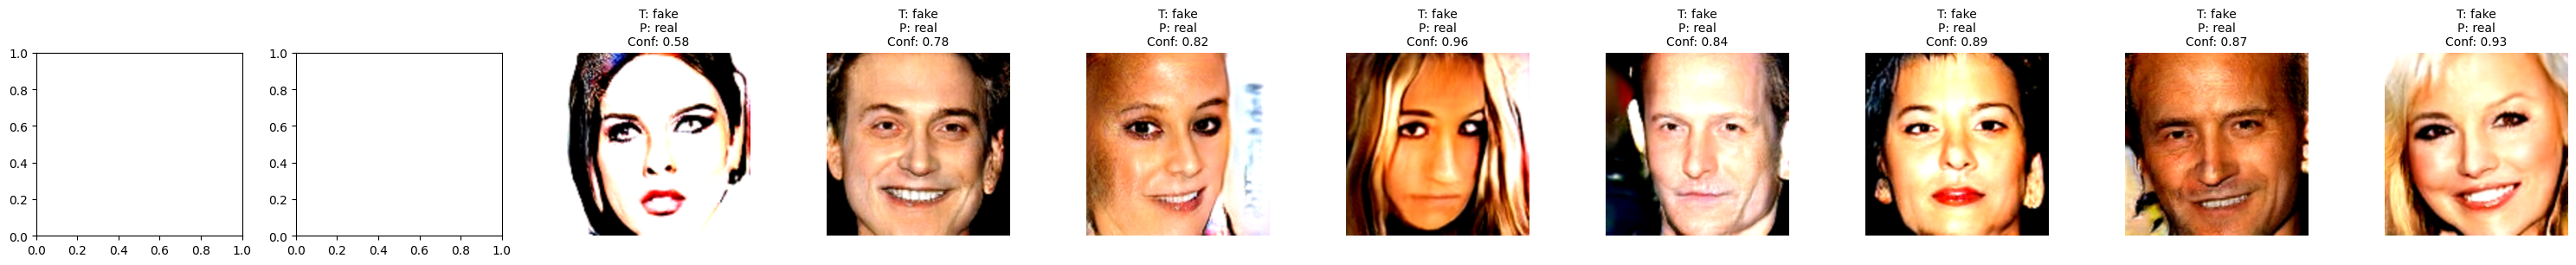

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_qualitative_results(model, dataloader, device, class_names, num_images=10):
    model.eval()
    images_shown = 2
    fig, axs = plt.subplots(1, num_images, figsize=(num_images*3, 3))

    # If only one image, axs is not a list, so we make it one.
    if num_images == 4:
        axs = [axs]

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            fused_logits = outputs['fused_logits']
            probs = torch.softmax(fused_logits, dim=1)
            preds = torch.argmax(fused_logits, dim=1)

            for i in range(imgs.size(0)):
                if images_shown >= num_images:
                    break

                # Denormalize: inverse normalization assuming mean=0.5 and std=0.5 for each channel.
                img = imgs[i].cpu() * 0.5 + 0.5
                img = img.permute(1, 2, 0).numpy()

                true_label = class_names[labels[i].item()]
                pred_label = class_names[preds[i].item()]
                confidence = probs[i][preds[i].item()].item()

                title = f"T: {true_label}\nP: {pred_label}\nConf: {confidence:.2f}"

                axs[images_shown].imshow(img)
                axs[images_shown].axis('off')
                axs[images_shown].set_title(title, fontsize=10)

                images_shown += 1
            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

# Assuming your ImageFolder dataset has a 'classes' attribute, e.g., ['Real', 'Fake']
class_names = train_data.classes  # or explicitly: class_names = ['Real', 'Fake']

# Display qualitative results using the test set (change num_images as desired)
display_qualitative_results(model, test_loader, device, class_names, num_images=10)
